In [1]:
import pandas as pd 
import numpy as np

In [ ]:
# create date range
dates = pd.date_range(start="2021-01-01", end="2022-12-31", freq="D")

# simulate UK-style temperature (cold winters, mild summers)
temp = 10 + 8 * np.sin(2 * np.pi * dates.dayofyear / 365) + np.random.normal(0, 1.5, len(dates))

# simulate UK gas demand (higher when temperature is lower)
demand = 3000 - 120 * temp + np.random.normal(0, 150, len(dates))

df = pd.DataFrame({
    "date": dates,
    "demand_gwh": demand,
    "mean_temp_c": temp
})

df.head()


,date,demand_gwh,mean_temp_c
0,2021-01-01,1796.316109,11.306823
1,2021-01-02,1699.980367,10.647691
2,2021-01-03,1258.942181,12.680196
3,2021-01-04,1721.386884,11.968642
4,2021-01-05,1633.951663,13.228335


In [5]:
# Heating Degree Days (UK standard baseline ~15.5°C)
df["hdd"] = (15.5 - df["mean_temp_c"]).clip(lower=0)

df.head()


,date,demand_gwh,mean_temp_c,hdd
0,2021-01-01,1796.316109,11.306823,4.193177
1,2021-01-02,1699.980367,10.647691,4.852309
2,2021-01-03,1258.942181,12.680196,2.819804
3,2021-01-04,1721.386884,11.968642,3.531358
4,2021-01-05,1633.951663,13.228335,2.271665


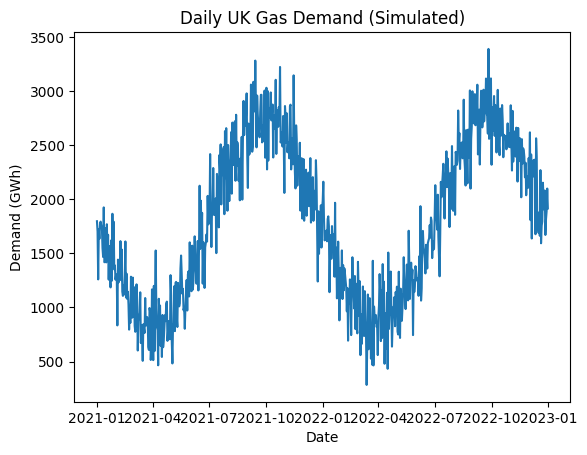

In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df["date"], df["demand_gwh"])
plt.title("Daily UK Gas Demand (Simulated)")
plt.xlabel("Date")
plt.ylabel("Demand (GWh)")
plt.show()


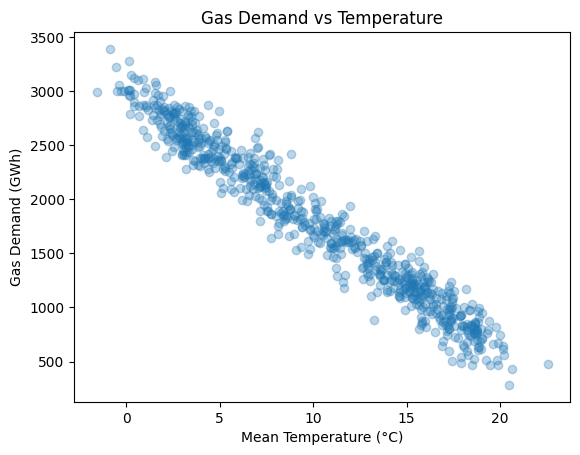

In [7]:
plt.figure()
plt.scatter(df["mean_temp_c"], df["demand_gwh"], alpha=0.3)
plt.xlabel("Mean Temperature (°C)")
plt.ylabel("Gas Demand (GWh)")
plt.title("Gas Demand vs Temperature")
plt.show()


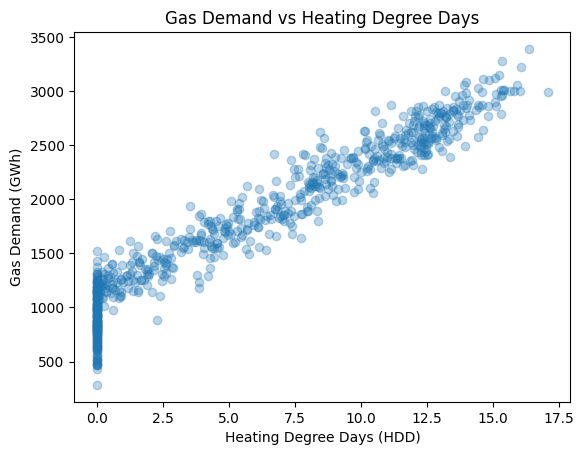

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(df["hdd"], df["demand_gwh"], alpha=0.3)
plt.xlabel("Heating Degree Days (HDD)")
plt.ylabel("Gas Demand (GWh)")
plt.title("Gas Demand vs Heating Degree Days")
plt.show()


In [9]:
df[["demand_gwh", "mean_temp_c", "hdd"]].corr()


,demand_gwh,mean_temp_c,hdd
demand_gwh,1.000000,-0.977112,0.964991
mean_temp_c,-0.977112,1.000000,-0.987177
hdd,0.964991,-0.987177,1.000000


In [10]:
df["demand_lag_1"] = df["demand_gwh"].shift(1)
df["demand_lag_7"] = df["demand_gwh"].shift(7)

df.head(10)


,date,demand_gwh,mean_temp_c,hdd,demand_lag_1,demand_lag_7
0,2021-01-01,1796.316109,11.306823,4.193177,NaN,NaN
1,2021-01-02,1699.980367,10.647691,4.852309,1796.316109,NaN
2,2021-01-03,1258.942181,12.680196,2.819804,1699.980367,NaN
3,2021-01-04,1721.386884,11.968642,3.531358,1258.942181,NaN
4,2021-01-05,1633.951663,13.228335,2.271665,1721.386884,NaN
5,2021-01-06,1777.818171,9.770119,5.729881,1633.951663,NaN
6,2021-01-07,1792.769276,9.534447,5.965553,1777.818171,NaN
7,2021-01-08,1756.133045,11.184024,4.315976,1792.769276,1796.316109
8,2021-01-09,1736.555049,10.033666,5.466334,1756.133045,1699.980367
9,2021-01-10,1547.025612,11.075337,4.424663,1736.555049,1258.942181


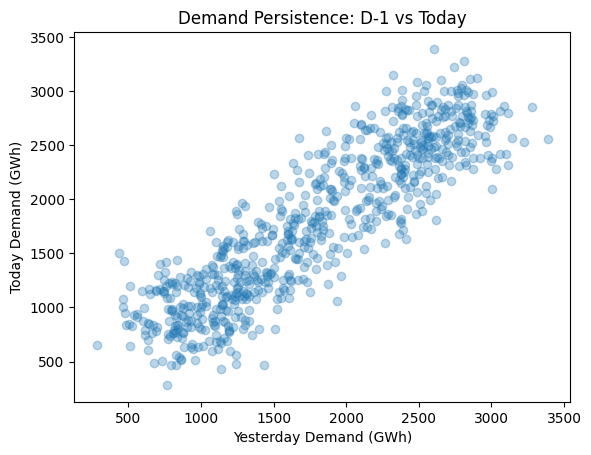

In [11]:
plt.figure()
plt.scatter(df["demand_lag_1"], df["demand_gwh"], alpha=0.3)
plt.xlabel("Yesterday Demand (GWh)")
plt.ylabel("Today Demand (GWh)")
plt.title("Demand Persistence: D-1 vs Today")
plt.show()


In [12]:
df["demand_roll_7"] = df["demand_gwh"].rolling(7).mean()
df["demand_roll_14"] = df["demand_gwh"].rolling(14).mean()

df.head(15)


,date,demand_gwh,mean_temp_c,hdd,demand_lag_1,demand_lag_7,demand_roll_7,demand_roll_14
0,2021-01-01,1796.316109,11.306823,4.193177,NaN,NaN,NaN,NaN
1,2021-01-02,1699.980367,10.647691,4.852309,1796.316109,NaN,NaN,NaN
2,2021-01-03,1258.942181,12.680196,2.819804,1699.980367,NaN,NaN,NaN
3,2021-01-04,1721.386884,11.968642,3.531358,1258.942181,NaN,NaN,NaN
4,2021-01-05,1633.951663,13.228335,2.271665,1721.386884,NaN,NaN,NaN
5,2021-01-06,1777.818171,9.770119,5.729881,1633.951663,NaN,NaN,NaN
6,2021-01-07,1792.769276,9.534447,5.965553,1777.818171,NaN,1668.737807,NaN
7,2021-01-08,1756.133045,11.184024,4.315976,1792.769276,1796.316109,1662.997369,NaN
8,2021-01-09,1736.555049,10.033666,5.466334,1756.133045,1699.980367,1668.222324,NaN
9,2021-01-10,1547.025612,11.075337,4.424663,1736.555049,1258.942181,1709.377100,NaN


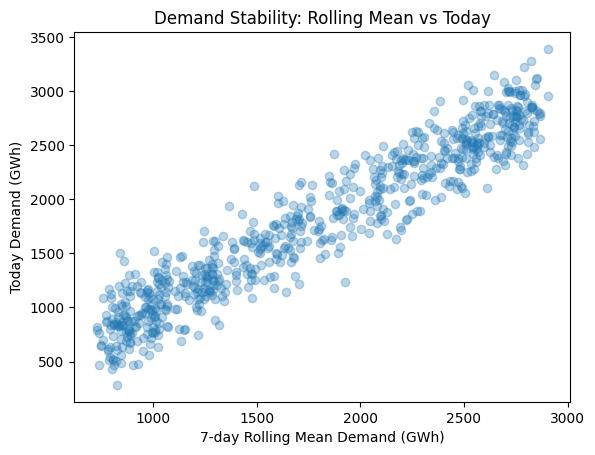

In [13]:
plt.figure()
plt.scatter(df["demand_roll_7"], df["demand_gwh"], alpha=0.3)
plt.xlabel("7-day Rolling Mean Demand (GWh)")
plt.ylabel("Today Demand (GWh)")
plt.title("Demand Stability: Rolling Mean vs Today")
plt.show()


In [14]:
df[
    ["demand_gwh", "demand_lag_1", "demand_lag_7", "demand_roll_7", "demand_roll_14"]
].corr()


,demand_gwh,demand_lag_1,demand_lag_7,demand_roll_7,demand_roll_14
demand_gwh,1.000000,0.888655,0.890315,0.953261,0.945355
demand_lag_1,0.888655,1.000000,0.886486,0.953628,0.946370
demand_lag_7,0.890315,0.886486,1.000000,0.936750,0.950716
demand_roll_7,0.953261,0.953628,0.936750,1.000000,0.994234
demand_roll_14,0.945355,0.946370,0.950716,0.994234,1.000000


In [15]:
df_model = df.dropna().copy()


In [16]:
train_size = int(len(df_model) * 0.8)

train = df_model.iloc[:train_size]
test = df_model.iloc[train_size:]


In [17]:
test["baseline_pred"] = test["demand_lag_1"]


C:\Users\Aditya\AppData\Local\Temp\ipykernel_8960\4282314506.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["baseline_pred"] = test["demand_lag_1"]


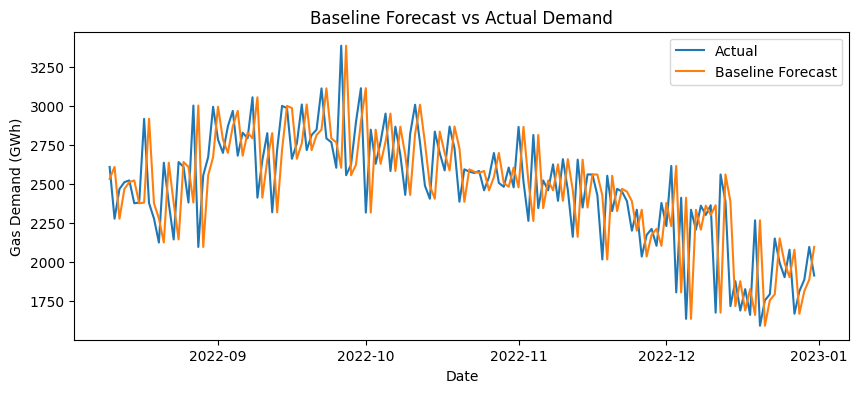

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(test["date"], test["demand_gwh"], label="Actual")
plt.plot(test["date"], test["baseline_pred"], label="Baseline Forecast")
plt.legend()
plt.title("Baseline Forecast vs Actual Demand")
plt.xlabel("Date")
plt.ylabel("Gas Demand (GWh)")
plt.show()


In [19]:
from sklearn.metrics import mean_absolute_error

mae_baseline = mean_absolute_error(
    test["demand_gwh"],
    test["baseline_pred"]
)

mae_baseline


263.2977903389018

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error


In [21]:
features = [
    "hdd",
    "demand_lag_1",
    "demand_lag_7",
    "demand_roll_7"
]

X_train = train[features]
y_train = train["demand_gwh"]

X_test = test[features]
y_test = test["demand_gwh"]


In [22]:
lr = LinearRegression()
lr.fit(X_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [23]:
test["lr_pred"] = lr.predict(X_test)


C:\Users\Aditya\AppData\Local\Temp\ipykernel_8960\1182857081.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["lr_pred"] = lr.predict(X_test)


In [24]:
mae_lr = mean_absolute_error(y_test, test["lr_pred"])
mae_lr


117.49211950348634

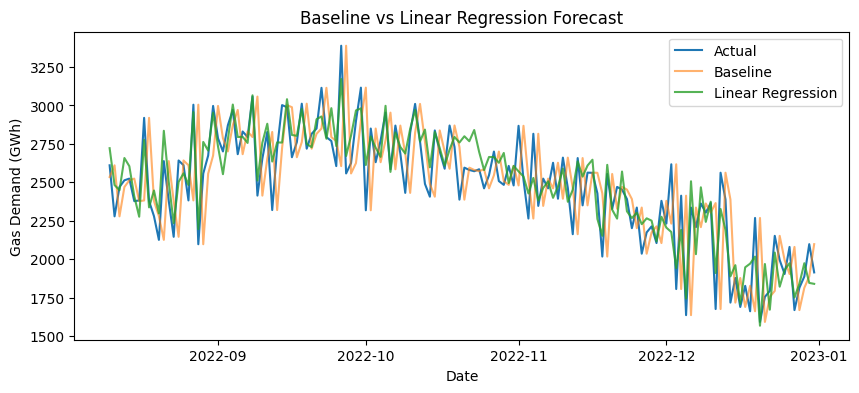

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(test["date"], y_test, label="Actual")
plt.plot(test["date"], test["baseline_pred"], label="Baseline", alpha=0.6)
plt.plot(test["date"], test["lr_pred"], label="Linear Regression", alpha=0.8)
plt.legend()
plt.title("Baseline vs Linear Regression Forecast")
plt.xlabel("Date")
plt.ylabel("Gas Demand (GWh)")
plt.show()


In [26]:
pd.Series(lr.coef_, index=features)


hdd              88.885647
demand_lag_1     -0.138732
demand_lag_7     -0.074795
demand_roll_7     0.566613
dtype: float64

# Phase 2 – Real UK Gas Demand Data (NTS Actual D+6)

In this section, we replace synthetic data with real UK National Transmission System
actual demand data sourced from the National Gas Data Portal.
The downstream feature engineering and models remain unchanged.


In [32]:
import pandas as pd

demand_raw = pd.read_csv(
    "../data/raw/uk_gas_demand_daily.csv"
)

demand_raw.head()




,Applicable At,Applicable For,Data Item,Value,Generated Time,Quality Indicator
0,15/01/2026 10:20:01,09/01/2026,"Demand Actual, NTS, D+6",321.824,15/01/2026 12:00:00,NaN
1,14/01/2026 10:20:00,08/01/2026,"Demand Actual, NTS, D+6",357.490,14/01/2026 12:00:00,NaN
2,13/01/2026 10:20:01,07/01/2026,"Demand Actual, NTS, D+6",339.761,13/01/2026 12:00:00,NaN
3,12/01/2026 10:20:00,06/01/2026,"Demand Actual, NTS, D+6",378.123,12/01/2026 12:00:00,NaN
4,11/01/2026 10:20:01,05/01/2026,"Demand Actual, NTS, D+6",407.523,11/01/2026 12:00:00,NaN


In [33]:
demand_raw["Applicable For"] = pd.to_datetime(demand_raw["Applicable For"], dayfirst=True)
demand_raw["Generated Time"] = pd.to_datetime(demand_raw["Generated Time"])

demand_raw.dtypes


C:\Users\Aditya\AppData\Local\Temp\ipykernel_8960\3397231416.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  demand_raw["Generated Time"] = pd.to_datetime(demand_raw["Generated Time"])


Applicable At                object
Applicable For       datetime64[ns]
Data Item                    object
Value                       float64
Generated Time       datetime64[ns]
Quality Indicator            object
dtype: object

In [34]:
demand_raw["Applicable For"].value_counts().head()


Applicable For
2021-02-22    5
2021-02-21    4
2021-03-28    4
2022-04-05    4
2022-04-06    4
Name: count, dtype: int64

In [35]:
demand_raw["Value"].describe()


count    2976.000000
mean      230.493232
std       121.882949
min         0.000000
25%       180.034500
50%       224.203162
75%       270.814851
max      5810.298990
Name: Value, dtype: float64

In [36]:
# sort so latest publication comes last
demand_sorted = demand_raw.sort_values(
    ["Applicable For", "Generated Time"]
)

# keep the latest record per Gas Day
demand_daily = demand_sorted.drop_duplicates(
    subset=["Applicable For"],
    keep="last"
).copy()

demand_daily.head()


,Applicable At,Applicable For,Data Item,Value,Generated Time,Quality Indicator
2973,17/01/2021 12:30:59,2021-01-11,"Demand Actual, NTS, D+6",327.862363,2021-04-28 16:08:01,L
2970,18/01/2021 12:30:59,2021-01-12,"Demand Actual, NTS, D+6",350.111724,2021-04-28 16:08:01,L
2967,19/01/2021 12:30:59,2021-01-13,"Demand Actual, NTS, D+6",355.076835,2021-04-28 16:08:01,L
2964,20/01/2021 12:30:59,2021-01-14,"Demand Actual, NTS, D+6",357.114328,2021-04-28 16:08:01,L
2961,21/01/2021 12:30:59,2021-01-15,"Demand Actual, NTS, D+6",362.616582,2021-04-28 16:08:01,L


In [37]:
# one row per gas day
demand_daily["Applicable For"].is_unique


True

In [38]:
# compare counts
len(demand_raw), len(demand_daily)


(2976, 1825)

In [39]:
demand_daily["Value"].describe()


count    1825.000000
mean      218.240701
std        64.623203
min        91.816700
25%       161.080000
50%       215.156000
75%       264.043949
max       416.427180
Name: Value, dtype: float64